## Packages

Let's run the cell below to import all the packages needed.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Conv2D, BatchNormalization
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib widget
import matplotlib.pyplot as plt
import VGG16utils


### Loading the data

In [2]:
X_train = np.load("savedData/150x150_propVal_aug_balanced/real/x_train.npy")
Y_train = np.load("savedData/150x150_propVal_aug_balanced/real/y_train.npy")
x_val=np.load("savedData/150x150_propVal_aug_balanced/real/x_val.npy") #cross validation data 
y_val=np.load("savedData/150x150_propVal_aug_balanced/real/y_val.npy") #cross validation data 
x_test=np.load("savedData/150x150_propVal_aug_balanced/real/x_test.npy") #test set image
y_test=np.load("savedData/150x150_propVal_aug_balanced/real/y_test.npy") #test set classification

### Visualisation

we can print the shape of each array

In [3]:
print("the shape of X_train is", X_train.shape)
print("the shape of y is", Y_train.shape)
print("x_small shape is", x_val.shape)
print("y_small shape is", y_val.shape)
print("x_test shape is", x_test.shape)
print("y_test shape is ", y_test.shape)

the shape of X_train is (9564, 150, 150, 1)
the shape of y is (9564,)
x_small shape is (1044, 150, 150, 1)
y_small shape is (1044,)
x_test shape is (624, 150, 150, 1)
y_test shape is  (624,)


### VGG16
we now need to set up vgg16 and reprapre the data

In [4]:
#Be careful run only one this code otherwise adding too much dim or reload the code 2 row above
X_rgb = np.repeat(X_train[:, :,:, np.newaxis], 3, axis=3)
print("X_rgb shape is", X_rgb.shape)
x_val=np.repeat(x_val[:, :,:, np.newaxis], 3, axis=3)
x_test=np.repeat(x_test[:, :,:, np.newaxis], 3, axis=3)

X_train=X_rgb
inputShape=np.squeeze(X_train[0],axis=-1).shape

X_rgb shape is (9564, 150, 150, 3, 1)


In [5]:
vgg_layer = VGG16(weights='imagenet', include_top=False, input_shape=inputShape)
vgg_layer.trainable=False

## Convolutional Neural Network

we can now implement our CNN model

In [6]:
#code assignment starts here

VGG_model = Sequential((
    [
        (vgg_layer),
        (Flatten()),
        (Dense(units = 64 , activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        (Dense(units = 3 , activation = 'linear')) 
    ]
),name='CNN')

VGG_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #prefered way of implementing a softmax
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

#code assignment stops here

we can check our model's detail

In [7]:
VGG_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 15,239,235
Trainable params: 524,547
Non-trainable params: 14,714,688
_________________________________________________________________


We use a a function that stop when the val encounter a plateau in order to avoid overfittin

In [8]:
Reduce_LR = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Testing

we can then fit our model and our data


In [9]:
#code from the assignment start here:
history = VGG_model.fit(
    X_train,Y_train,
    epochs=30,
    validation_data = (x_val, y_val),
    callbacks= [early_stopping,Reduce_LR],
)

#end of the code from assignment

Epoch 1/30
299/299 [==============================] - 643s 2s/step - loss: 1.2466 - accuracy: 0.7158 - val_loss: 0.7071 - val_accuracy: 0.7577 - lr: 0.0010
Epoch 2/30
299/299 [==============================] - 11528s 39s/step - loss: 0.7223 - accuracy: 0.7274 - val_loss: 0.6797 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 3/30
299/299 [==============================] - 614s 2s/step - loss: 0.7122 - accuracy: 0.7286 - val_loss: 0.7410 - val_accuracy: 0.7184 - lr: 0.0010
Epoch 4/30
299/299 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.7387
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
299/299 [==============================] - 653s 2s/step - loss: 0.6855 - accuracy: 0.7387 - val_loss: 0.8473 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 5/30
299/299 [==============================] - 659s 2s/step - loss: 0.6191 - accuracy: 0.7687 - val_loss: 0.6016 - val_accuracy: 0.7682 - lr: 3.0000e-04
Epoch 6/30
299/299 [==============================] 

### Metrics on train set

We can observe the metrics of the model

In [10]:
# Prediction on our training data
y_pred_train = VGG_model.predict(X_train)

#beginning of code from the assignment for softmax uses
prediction_p = tf.nn.softmax(y_pred_train)
y_pred_classes = np.argmax(prediction_p, axis=1)
#enf od code from assignment



In [11]:
print(classification_report(Y_train, y_pred_classes,zero_division=1, target_names = ['Normal (Class 0)','Bacteria (Class 1)','Viral (class 2)']))
print("Loss of the model is - " , VGG_model.evaluate(X_train,Y_train)[0])
print("Accuracy of the model is - " , VGG_model.evaluate(X_train,Y_train)[1]*100 , "%")

                    precision    recall  f1-score   support

  Normal (Class 0)       0.91      0.96      0.94      3168
Bacteria (Class 1)       0.71      0.80      0.75      3198
   Viral (class 2)       0.76      0.63      0.69      3198

          accuracy                           0.80      9564
         macro avg       0.80      0.80      0.79      9564
      weighted avg       0.80      0.80      0.79      9564

299/299 [==============================] - 598s 2s/step - loss: 0.5481 - accuracy: 0.7966
Loss of the model is -  0.5481318235397339
299/299 [==============================] - 598s 2s/step - loss: 0.5481 - accuracy: 0.7966
Accuracy of the model is -  79.66331839561462 %


#### overfitting
We can plot the training accuracy and the validation accuracy to have a first idea of the overfitting of our model. If the Validation accuracy stops or decrease and the training one is increasing that might indicate case of overfitting the training set.
If the validation loss keep increasing and the training one keep decreasing that might suggest overfitting

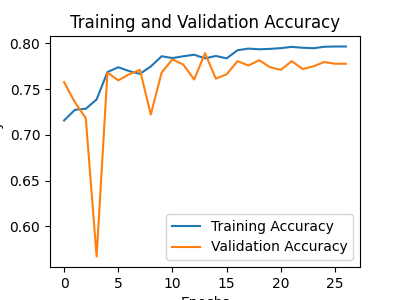

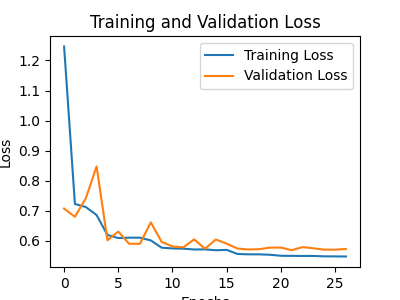

In [12]:
VGG16utils.plt_Training_Val_Accuracy(history)
VGG16utils.plt_Training_Val_loss(history)

### Prediction
we can now try our model on the test set


In [13]:
#prediction on the test set
y_pred_test=VGG_model.predict(x_test)

#beginning of code from the assignment for softmax uses
prediction = tf.nn.softmax(y_pred_test)
prediction_classes = np.argmax(prediction, axis=1)
#enf od code from assignment

#print partly of the result
print("the first ten classes are :", prediction_classes[:10])

the first ten classes are : [0 0 0 1 0 0 0 0 1 0]


### Analysis of the prediction

we can calculate the metrics of our prediction of the test set this time to have even more information of our model

                    precision    recall  f1-score   support

  Normal (Class 0)       0.95      0.69      0.80       234
Bacteria (Class 1)       0.84      0.94      0.89       242
   Viral (class 2)       0.68      0.84      0.75       148

          accuracy                           0.82       624
         macro avg       0.82      0.82      0.81       624
      weighted avg       0.84      0.82      0.82       624



20/20 [==============================] - 40s 2s/step - loss: 0.6850 - accuracy: 0.8237
Loss of the model is -  0.6849797368049622
20/20 [==============================] - 41s 2s/step - loss: 0.6850 - accuracy: 0.8237
Accuracy of the model is -  82.37179517745972 %


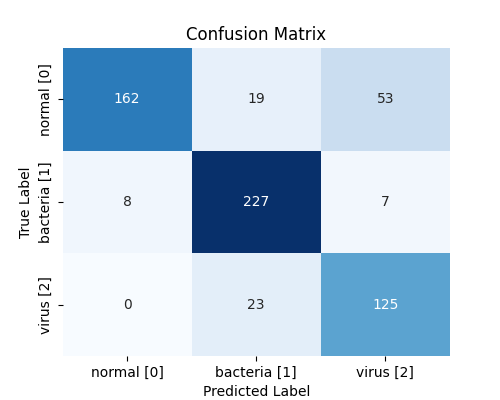

In [14]:
print(classification_report(y_test, prediction_classes,zero_division=1, target_names = ['Normal (Class 0)','Bacteria (Class 1)','Viral (class 2)']))
print("Loss of the model is - " , VGG_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , VGG_model.evaluate(x_test,y_test)[1]*100 , "%")

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, prediction_classes)
VGG16utils.plt_conf_matrix(conf_matrix)


In [15]:
VGG16utils.plot_roc_curve(y_test, prediction_classes, 3)

AttributeError: module 'VGG16utils' has no attribute 'plot_roc_curve'